## Advanced Control Methods | Assignment 1

### Birdview

The course on the Advanced Control Methods is being delivered by the Labortory of Artificial Intelligence in Dynamic Action(AIDA). The majority of the assignments will involve the usage of *rcognita* - a framework for simulation and visualization of the dynamical systems, that is under development in the laboratory.

There will be four assignments in the couse:
- NN Estimator
- Model Predictive Control (MPC)
- Kalman filter
- Classical CV-based recognition

Each of the assignments will be given after a lecture and a seminar on the topic it involves.

### Introduction & theory recap

The two-wheeled floor robot is set to perform a circular motion with control that is constant over time. This assignment is devoted to the implementation of an estimator - a neural network, that predicts the next state of the dynamical system (of our robot) given the current state and current control. The system is considered as a discrete one. Specifically,

$x_k$ - state from state space $\mathbb{X}$

$u_k$ - action from action space $\mathbb{U}$,

and we are interested in **learning** a function *e* (estimator) such that

$x_{k+1} = e(x_k, u_k)$

We will do that that via gradient gescent with pytorch. In the first half of the assignment the estimator will be trained on a pre-recorded state-action trajetory, and in the second it will train on the fly on a sliding buffer with the recent states and actions.

### Problem statement

The assignment consists of three parts. The first and the second are (for the sake of speeding up the calculations) organized in the form of the default ML setting: there is a fixed dataset and the goal is to minimize a loss function over it. Note the form of the train-test split (by a cetrain point in time, not by random permutation) that is used in the Section 2.

In each section the places for your code are marked with

#############################################\
#YOUR CODE BELOW\
#############################################


#############################################\
#YOUR CODE ABOVE\
#############################################

Fill all of them, following the extended problem formulation in each section.

In short, the sections of the assignment are devoted to
- **Section 1:** familiarizing yourself to the state-action trajectory setting *code-wise*. Training the simplest NN possble to reproduce its input (also known as the Identity learning)
- **Section 2:** implementing models that are really capable of estimating something. Comparing them (mainly in visual form by their predictions in a range of hyperparameters
- **Section 3:** integrating the best model (the one with the best performing hyperparameters) in the simulation of the robot

Only the results of the section 3 will be graded. Although, it is necessary to build up the understanding via solving the problems that are given in the sections 1 and 2.

Note that in the third section there are cells that are necessary for rcognita to work. There is no need to dive very deeply into them (the assignment is about the estimator), but they are worth reading a couple of times just to get a sense of what's going on here.

[//]: # (First, let us install the *rcognita* package. !pip install rcognita)

***

<h2 style="color:#A7BD3F;">Section 1: Learning identity</h2>

Let us move towards the end goal via small incremental steps.

The first problem is devoted to the simplest case possible of the estimator learning. Here we will set up an estimator that will predict not the next state, but the current state. In other words, it will learn an identity function, mapping $x$ to $x$.

This problem will not be graded, it is here for demonstrational purposes only. As it was mentioned before, the learning here will be preformed on a pre-recorded buffer. Examine the code, the data preparation. *x* coordinate of the robot is plotted as a function of time to check if the data makes sense.

Note the only parameter that is passed to the constructor of *ModelRNN_linear*. Function *model_out* inputs both observation and action, but the latter is ignored.

A single-layer neural network applies $Ax + b$ linear function to the input. Thus, after sufficient number of gradient descent steps, it is expected to *learn* nearly zero vector for $b$ and nearly identity matrix for $A$. In order to observe these parameters directly, they are printed after the training is complete.

The task here is to insert the code in two places in the cell below. Please make a neural network of a single fully connected layer and apply it to the input in the *forward* finction.

Are you happy with the loss decay rate? Try changing optimizer hyperparameters, try changing loss function. Try applying gradient clipping (which was originally intended to be a way of preventing gradients from exploding, see https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem for a detailed explanation) and compare the results.

Examine the NN weights after the training. Do they resemble an Identity matrix and a zero vector?

In [1]:
import pathlib
    
import warnings
import csv
from datetime import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

import importlib
import json

import torch
import torch.optim as optim
import torch.nn as nn

%matplotlib notebook
%load_ext autoreload
%autoreload 2

class ModelRNN_linear(nn.Module):
    def __init__(self, dim_observation):
        super().__init__()
        
        #self.criterion = nn.L1Loss()
        self.criterion = nn.MSELoss()
        
        #############################################
        # YOUR CODE BELOW
        #############################################
        
        self.layers = nn.Sequential(
            nn.Linear(dim_observation, dim_observation),
        )
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

        self.double()
        
    def forward(self, x):
        x = x.double()
        
        #############################################
        # YOUR CODE BELOW
        #############################################
        
        x = self.layers(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        to_torch = torch.tensor(observation)

        return self.forward(to_torch)

    def output_loss(self, observation, action, true_next_obs):
        """
        Return current loss
        """

        self.loss = 0

        observation_pred = self.model_out(observation, action)
        self.loss = self.criterion(observation_pred, torch.tensor(true_next_obs))
        
        return self.loss.detach().numpy()

Let us visualise the data. You will see the $x$ coordinate as a function of time.

Note that the length of the trajetory is $431$, while the simulation time is $6$ seconds, and the sampling time ($dt$) is $0.01$s. We could expect $600$ samples, but that is not the case. Let us take a brief look at that effect.

There are two sampling processes that are running simultaneously. First is the simulation of physics, that is run with variating timestamp, but not greater than $\frac{dt}{2}$. And the second is the control generation, that happends not more often than once in $dt$. Since both processes are (in implementation) discrete, the control generation begins with a delay after $dt$ passed, which results in the lower sampling frequency. Refer to the method *compute_action* of *CtrlNominal3WRobotNI* class from *controllers.py* for an implementation.

<IPython.core.display.Javascript object>


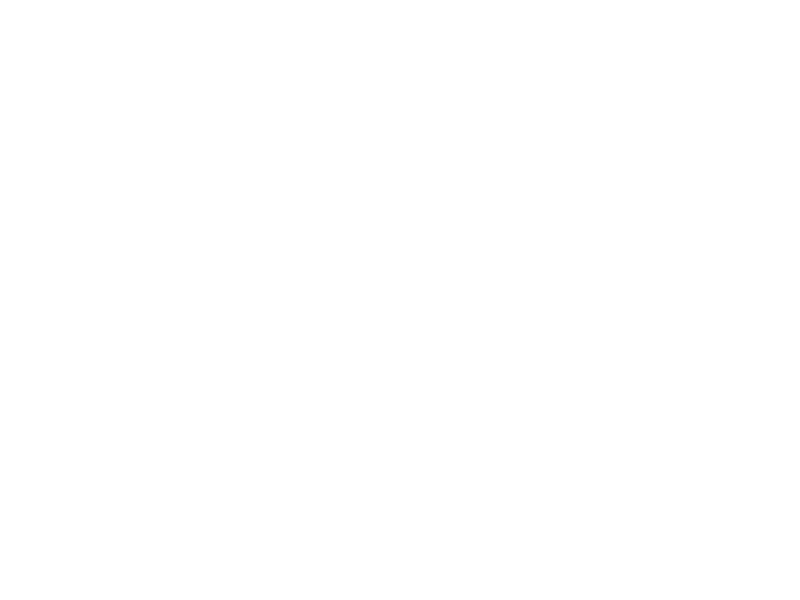

431


In [2]:
from grading_utilities import load_from_json
import matplotlib.pyplot as plt

dat = load_from_json("obs_traj.json")

traj = dat["trajectory_log"]["observation_action_traj"]

x = []
y = []

for i in range(len(traj)):
    x.append(traj[i][1][0])
    y.append(traj[i][1][1])

fig, ax = plt.subplots()
ax.set_xlabel('tick num')
ax.set_ylabel('x[m]')
ax.plot(x)
plt.show()

data = []

for i in range(len(traj)):
    data.append([np.array(traj[i][1]), traj[i][2]])

print(len(data))

In [3]:
model = ModelRNN_linear(3)

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

for param in model.parameters():
    print(param.data)

print("avg loss for each 5th epoch:")

for j in range(25):
    acc_loss = 0
    
    for i, (state, action) in enumerate(data):
        optimizer.zero_grad()
        
        loss_val = model.output_loss(state, action, state)
        
        acc_loss += loss_val
        
        model.loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
        optimizer.step()
    
    if (j % 6 == 0):
        print(acc_loss / len(data))

        print("")
        print("model parameters after training:")

        for param in model.parameters():
            print(param.data)

tensor([[-0.5236, -0.3338,  0.0144],
        [-0.2431,  0.4154, -0.0233],
        [-0.3963,  0.4531,  0.2454]], dtype=torch.float64)
tensor([-0.2744,  0.3913,  0.1880], dtype=torch.float64)
avg loss for each 5th epoch:
3.7978472760311477

model parameters after training:
tensor([[ 1.1236, -0.3949,  0.6341],
        [-0.1020,  1.4020, -0.4527],
        [ 0.0755, -0.1437,  1.4106]], dtype=torch.float64)
tensor([-0.7466,  0.2025, -0.8228], dtype=torch.float64)
0.004730493825669053

model parameters after training:
tensor([[ 1.0439,  0.0054, -0.1956],
        [ 0.0381,  0.9096,  0.1191],
        [ 0.0733, -0.0665,  0.8490]], dtype=torch.float64)
tensor([ 0.0990, -0.1801,  0.0623], dtype=torch.float64)
0.0077000509355571135

model parameters after training:
tensor([[ 0.9819,  0.0553, -0.0143],
        [ 0.0499,  0.9325, -0.0609],
        [-0.0080,  0.0485,  0.9475]], dtype=torch.float64)
tensor([-0.0397,  0.0316, -0.0037], dtype=torch.float64)
0.0005169969275478922

model parameters after t

***

<h2 style="color:#A7BD3F;">Section 2: Trying out models</h2>

Let us move on to the non-trivial models, that exceed a single linear layer. The assignment is to implement two models: with a single hidden layer and with two hidden layers. A draft for the first one is provided.

Note the differences in the parameters that are passed to the constructor in comparison with the previous section. Here we not only take *dim_action* as a parameter, but also attempt to create a general enough estimator, making it possible to vary the size of the hidden layer with *dim_hidden*. For convenience the string parameter setting the optimization criterion (with two options, feel free to add more) is introduced.

In [4]:
class ModelRNN(nn.Module):
    def __init__(self, dim_observation, dim_action, dim_hidden, criterion="L1"):
        super().__init__()
        
        print(criterion)
        
        if (criterion == "L1"):
            self.criterion = nn.L1Loss()
        
        else:
            if (criterion != "MSE"):
                print(criterion, "criterion is not supported. Using MSE as a loss")
            
            self.criterion = nn.MSELoss()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        self.layers = nn.Sequential(
            nn.Linear(dim_observation + dim_action, dim_hidden),
            nn.Linear(dim_hidden, dim_observation),
        )
    
        #############################################
        # YOUR CODE ABOVE
        #############################################

        self.double()
        
    def forward(self, x):
        x = x.double()

        #############################################
        # YOUR CODE BELOW
        #############################################

        x = self.layers(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        concat = np.concatenate((observation, action))
        to_torch = torch.tensor(concat)

        return self.forward(to_torch)
        
    def output_loss(self, observation, action, true_next_obs):
        """
        Return current loss
        """

        self.loss = 0

        observation_pred = self.model_out(observation, action)
        self.loss = self.criterion(observation_pred, torch.tensor(true_next_obs))
        
        return self.loss.detach().numpy()

class ModelRNN_deeper(nn.Module):
    def __init__(self, dim_observation, dim_action, dim_hidden, criterion="L1"):
        super().__init__()
        
        print(criterion, "loss")
        
        if (criterion == "L1"):
            self.criterion = nn.L1Loss()
        
        else:
            if (criterion != "MSE"):
                print(criterion, "criterion is not supported. Using MSE as a loss")
            
            self.criterion = nn.MSELoss()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        self.layers = nn.Sequential(
            nn.Linear(dim_observation + dim_action, dim_hidden),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Linear(dim_hidden, dim_observation),
        )
    
        #############################################
        # YOUR CODE ABOVE
        #############################################

        self.double()
        
    def forward(self, x):
        x = x.double()

        #############################################
        # YOUR CODE BELOW
        #############################################

        x = self.layers(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        concat = np.concatenate((observation, action))
        to_torch = torch.tensor(concat)

        return self.forward(to_torch)
        
    def output_loss(self, observation, action, true_next_obs):
        """
        Return current loss
        """

        self.loss = 0

        observation_pred = self.model_out(observation, action)
        self.loss = self.criterion(observation_pred, torch.tensor(true_next_obs))
        
        return self.loss.detach().numpy()

Examine the following code. It sets up an interactive environment for the NN training. It could be trained with different number of epochs, different size of the hidden layer, and different length of the trajectory that is observed.

*update()* function is called each time any of the trackbars are moved. This function trains a network from scratch and visualizes its result on the whole dataset. The results are shown in green. The recorded trajectory of the robot is drawn in blue (the train set for a net) and in orange.

Try to note the cause-effect relations as you change the parameters for the training. Note the impact of the change of the train set size on the performance of the model. Note the impact of the model size on the training time.

Feel free to experiment with the train loop: you could introduce minibatches, add new loss functions vary hyperparameters, experiment with the network architecture, if you feel like doing so.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


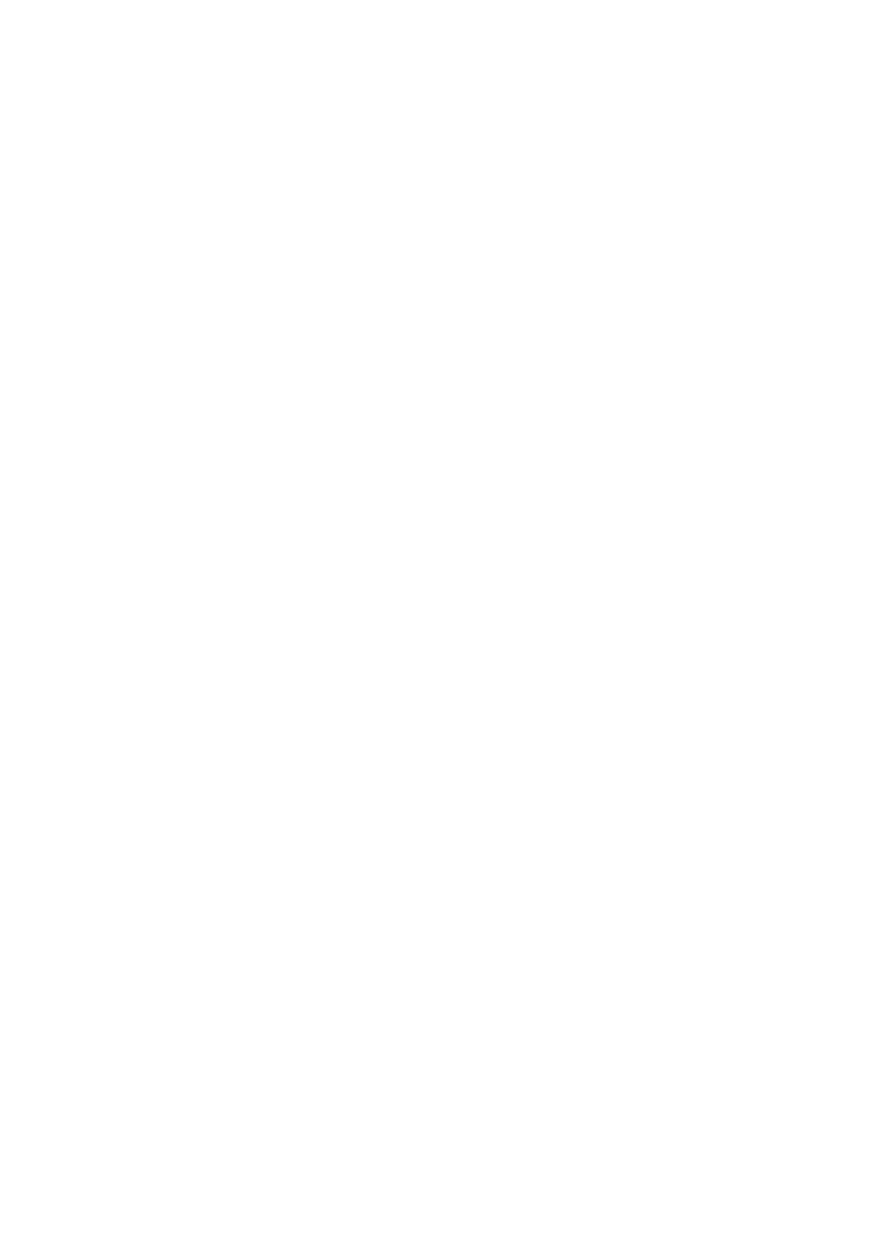

L1


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

%matplotlib notebook
%load_ext autoreload
%autoreload 2

fig, ax = plt.subplots(figsize=(7, 10))
plt.subplots_adjust(bottom=0.35)
plt.xlim([-15, 25])
plt.ylim([-15, 25])
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')

true_traj1, = plt.plot(x, y)
true_traj2, = plt.plot(x, y)
pred_traj,  = plt.plot(x, y)
 
axbuff = plt.axes([0.25, 0.15, 0.65, 0.03])
axhidd = plt.axes([0.25, 0.20, 0.65, 0.03])
axepochs = plt.axes([0.25, 0.25, 0.65, 0.03])

buff = Slider(axbuff, 'Buffer size', 100, len(data), 300)
hidd = Slider(axhidd, 'Hidden layer size', 2, 20, 10)
epochs = Slider(axepochs, 'Epochs number', 1, 40, 10)

def update(val):
    buffer_size = int(buff.val)
    hidden_layer_size = int(hidd.val)
    epochs_num = int(epochs.val)
    
    model = ModelRNN(3, 2, hidden_layer_size)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
    BUF_SHIFT    = 0
    TEST_BUF_LEN = 500
    
    for _ in range(epochs_num):
        for i, (state, action) in enumerate(data[BUF_SHIFT : BUF_SHIFT + buffer_size]):
            optimizer.zero_grad()
            
            next_state, _ = data[BUF_SHIFT + i + 1]

            loss_val = model.output_loss(state, action, next_state)

            model.loss.backward()

            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

            optimizer.step()
    
    x_curr = data[0][0][0]
    y_curr = data[0][0][1]
    
    pred_traj_x = []
    pred_traj_y = []
    
    for i in range(0, len(data)):
        observation = data[i][0]
        action      = data[i][1]
        
        x_pred, y_pred = model.model_out(observation, action).detach().numpy()[:2]
        
        pred_traj_x.append(x_pred)
        pred_traj_y.append(y_pred)
        
        x_curr, y_curr = x_pred, y_pred
        
    true_traj1.set_xdata(x[:BUF_SHIFT + buffer_size])
    true_traj1.set_ydata(y[:BUF_SHIFT + buffer_size])

    true_traj2.set_xdata(x[BUF_SHIFT + buffer_size:])
    true_traj2.set_ydata(y[BUF_SHIFT + buffer_size:])

    pred_traj.set_xdata(pred_traj_x)
    pred_traj.set_ydata(pred_traj_y)

update(0)

buff.on_changed(update)
hidd.on_changed(update)
epochs.on_changed(update)

plt.show()

***

<h2 style="color:#A7BD3F;">Section 3: composing with rcognita</h2>

After the estimator is debugged and tested with different parameters, let us apply it "in the field". Essentially it will be the same training process, but it will be performed *during the simulation*. Here we do not use the learned model in the control generation (the control is constant), but in real applications the whole point of the estimator is to learn the model as precisely as possible, given limited (precisely to one trajectory) data.

Take some time to examine the following cell, to read through the parts that constitute the simulation.

You should run all the code (from the cell below) every simulation. Otherwise it will not work, giving an optimizer error.

In [6]:
notebook_name = "asgn-1.ipynb"

import os, sys
__file__ = os.path.join(os.getcwd(),notebook_name)
PARENT_DIR = os.path.abspath(__file__ + '/../..')
sys.path.insert(0, PARENT_DIR)

import rcognita.rcognita

if os.path.abspath(rcognita.__file__ + "/../..") == PARENT_DIR:
    info = f"this script is being run using " \
           f"rcognita ({rcognita.rcognita.__version__}) " \
           f"located in cloned repository at '{PARENT_DIR}'. " \
           f"If you are willing to use your locally installed rcognita, " \
           f"run this script ('{os.path.basename(__file__)}') outside " \
           f"'rcognita/presets'."
else:
    info = f"this script is being run using " \
           f"locally installed rcognita ({rcognita.rcognita.__version__}). " \
           f"Make sure the versions match."
print("INFO:", info)

import pathlib
    
import warnings
import csv
from datetime import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from rcognita.rcognita import simulator
from rcognita.rcognita import systems
from rcognita.rcognita import controllers
from rcognita.rcognita import loggers
from rcognita.rcognita import visuals
from rcognita.rcognita import estimators
from rcognita.rcognita.utilities import on_key_press
from argparser_3wrobot_NI import parser
import importlib
import json
import rcognita.rcognita.models as models

from rcognita.rcognita.utilities import push_vec

import torch
import torch.optim as optim
import torch.nn as nn

%matplotlib notebook
%load_ext autoreload
%autoreload 2

dim_state = 3
dim_input = 2
dim_output = dim_state
dim_disturb = 0

dim_R1 = dim_output + dim_input
dim_R2 = dim_R1

args = parser.parse_args(["--is_visualization", "True"])

#print(args.dt)

if not isinstance(args.state_init[0], int):
    for k in range(len(args.state_init)):
        args.state_init[k] = eval( args.state_init[k].replace('pi', str(np.pi)) )

args.state_init = np.array(args.state_init)
args.action_manual = np.array(args.action_manual)

pred_step_size = args.dt * args.pred_step_size_multiplier
model_est_period = args.dt * args.model_est_period_multiplier
critic_period = args.dt * args.critic_period_multiplier

R1 = np.diag(np.array(args.R1_diag))
R2 = np.diag(np.array(args.R2_diag))

assert args.t1 > args.dt > 0.0
assert args.state_init.size == dim_state

globals().update(vars(args))

is_disturb = 0
is_dyn_ctrl = 0

t0 = 0

action_init = 0 * np.ones(dim_input)

# Solver
atol = 1e-5
rtol = 1e-3

# xy-plane
xMin = -10
xMax = 10
yMin = -10
yMax = 10

# Model estimator stores models in a stack and recall the best of model_est_checks
model_est_checks = 0

# Control constraints
v_min = -25
v_max = 25
omega_min = -5
omega_max = 5
ctrl_bnds=np.array([[v_min, v_max], [omega_min, omega_max]])

my_sys = systems.Sys3WRobotNI(sys_type="diff_eqn",
                                     dim_state=dim_state,
                                     dim_input=dim_input,
                                     dim_output=dim_output,
                                     dim_disturb=dim_disturb,
                                     pars=[],
                                     ctrl_bnds=ctrl_bnds,
                                     is_dyn_ctrl=is_dyn_ctrl,
                                     is_disturb=is_disturb,
                                     pars_disturb=[])

observation_init = my_sys.out(state_init)

xCoord0 = state_init[0]
yCoord0 = state_init[1]
alpha0 = state_init[2]
alpha_deg_0 = alpha0/2/np.pi

my_ctrl_nominal = controllers.CtrlNominal3WRobotNI(ctrl_gain=0.5, ctrl_bnds=ctrl_bnds, t0=t0, sampling_time=dt)

# Predictive optimal controller
my_ctrl_opt_pred = controllers.CtrlOptPred(dim_input,
                                           dim_output,
                                           ctrl_mode,
                                           ctrl_bnds = ctrl_bnds,
                                           action_init = [],
                                           t0 = t0,
                                           sampling_time = dt,
                                           Nactor = Nactor,
                                           pred_step_size = pred_step_size,
                                           sys_rhs = my_sys._state_dyn,
                                           sys_out = my_sys.out,
                                           state_sys = state_init,
                                           prob_noise_pow = prob_noise_pow,
                                           is_est_model = is_est_model,
                                           model_est_stage = model_est_stage,
                                           model_est_period = model_est_period,
                                           buffer_size = buffer_size,
                                           model_order = model_order,
                                           model_est_checks = model_est_checks,
                                           gamma = gamma,
                                           Ncritic = Ncritic,
                                           critic_period = critic_period,
                                           critic_struct = critic_struct,
                                           stage_obj_struct = stage_obj_struct,
                                           stage_obj_pars = [R1],
                                           observation_target = [])

my_ctrl_benchm = my_ctrl_opt_pred

my_simulator = simulator.Simulator(sys_type = "diff_eqn",
                                   closed_loop_rhs = my_sys.closed_loop_rhs,
                                   sys_out = my_sys.out,
                                   state_init = state_init,
                                   disturb_init = [],
                                   action_init = action_init,
                                   t0 = t0,
                                   t1 = t1,
                                   dt = dt,
                                   max_step = dt/2,
                                   first_step = 1e-6,
                                   atol = atol,
                                   rtol = rtol,
                                   is_disturb = is_disturb,
                                   is_dyn_ctrl = is_dyn_ctrl)
                                   
if os.path.basename( os.path.normpath( os.path.abspath(os.getcwd()) ) ) == 'presets':
    data_folder = '../simdata'
else:
    data_folder = 'simdata'

pathlib.Path(data_folder).mkdir(parents=True, exist_ok=True) 

date = datetime.now().strftime("%Y-%m-%d")
time = datetime.now().strftime("%Hh%Mm%Ss")
datafiles = [None] * Nruns

for k in range(0, Nruns):
    datafiles[k] = data_folder + '/' + my_sys.name + '__' + ctrl_mode + '__' + date + '__' + time + '__run{run:02d}.csv'.format(run=k+1)
    
    if is_log_data:
        print('Logging data to:    ' + datafiles[k])
            
        with open(datafiles[k], 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['System', my_sys.name ] )
            writer.writerow(['Controller', ctrl_mode ] )
            writer.writerow(['dt', str(dt) ] )
            writer.writerow(['state_init', str(state_init) ] )
            writer.writerow(['is_est_model', str(is_est_model) ] )
            writer.writerow(['model_est_stage', str(model_est_stage) ] )
            writer.writerow(['model_est_period_multiplier', str(model_est_period_multiplier) ] )
            writer.writerow(['model_order', str(model_order) ] )
            writer.writerow(['prob_noise_pow', str(prob_noise_pow) ] )
            writer.writerow(['Nactor', str(Nactor) ] )
            writer.writerow(['pred_step_size_multiplier', str(pred_step_size_multiplier) ] )
            writer.writerow(['buffer_size', str(buffer_size) ] )
            writer.writerow(['stage_obj_struct', str(stage_obj_struct) ] )
            writer.writerow(['R1_diag', str(R1_diag) ] )
            writer.writerow(['R2_diag', str(R2_diag) ] )
            writer.writerow(['Ncritic', str(Ncritic) ] )
            writer.writerow(['gamma', str(gamma) ] )
            writer.writerow(['critic_period_multiplier', str(critic_period_multiplier) ] )
            writer.writerow(['critic_struct', str(critic_struct) ] )
            writer.writerow(['actor_struct', str(actor_struct) ] )   
            writer.writerow(['t [s]', 'x [m]', 'y [m]', 'alpha [rad]', 'stage_obj', 'accum_obj', 'v [m/s]', 'omega [rad/s]'] )

INFO: this script is being run using locally installed rcognita (v0.1.2). Make sure the versions match.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Write all the necessary code for the backpropagation in *update_params*. Do not forget to use all the good practices that you've discovered previously.

If the neural network is not converging, make sure that you perform the optimization step.

Implement the loss calculation over a buffer in *output_loss*. Save the last estimator prediction in *self.last_pred*.

In [7]:
class EstimatorRNN:
    """
    Class of model estimators based on recurrent neural networks
    """

    def __init__(self, dim_observation, dim_action, dim_hidden, buffer_size,
                 model = None, Nbackprops = 1, t0=0, sampling_time=0.1):
        self.buffer_size = buffer_size

        self.dim_observation = dim_observation
        self.dim_action      = dim_action
        self.dim_hidden      = dim_hidden
        
        self.ctrl_clock    = t0
        self.sampling_time = sampling_time

        if (model is None):
            self.model = models.ModelRNN(None, self.dim_observation, self.dim_action, self.dim_hidden)

        else:
            self.model = model

        self.criterion = nn.L1Loss()
        #self.criterion = nn.MSELoss()

        self.optimizer = optim.SGD(self.model.parameters(), lr=0.0005, momentum=0.9)

        self.observation_buffer = np.zeros((self.buffer_size, self.dim_observation), dtype = np.float64)
        self.action_buffer      = np.zeros((self.buffer_size, self.dim_action), dtype = np.float64)

        self.Nbackprops = Nbackprops
        
    def receive_sys_IO(self, t, observation, action):
        time_in_sample = t - self.ctrl_clock

        if time_in_sample >= self.sampling_time:  # New sample
            self.ctrl_clock = t

            self.observation_buffer = push_vec(self.observation_buffer, observation)
            self.action_buffer      = push_vec(self.action_buffer, action)
            
            return True
        
        return False

    def update_params(self):
        """
        Update neural network weights
        """

        #############################################
        # YOUR CODE BELOW
        #############################################

        self.loss.backward()

        nn.utils.clip_grad_value_(self.model.parameters(), clip_value=1.0)

        self.optimizer.step()

        #############################################
        # YOUR CODE ABOVE
        #############################################

    def get_last_pred(self):
        return self.last_pred
    
    def output_loss(self):
        """
        Return current loss
        """

        self.loss = 0
        self.optimizer.zero_grad()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        concat = np.concatenate((self.observation_buffer[-2, :], self.action_buffer[-2, :]))
        to_torch = torch.tensor(concat)

        self.last_pred = self.model.forward(to_torch)

        self.l oss = self.criterion(self.last_pred, torch.tensor(self.observation_buffer[-1, :]))

        #############################################
        # YOUR CODE ABOVE
        #############################################    
        
        return self.loss.detach().numpy()

In [8]:
if is_print_sim_step:
    warnings.filterwarnings('ignore')
    
my_logger = loggers.Logger3WRobotNI()

Try different buffer sizes, hidden layer sizes. Try plugging multilayer model.

In [9]:


#############################################
# YOUR CODE (PARAMETERS) BELOW
#############################################

#model = ModelRNN_deeper(dim_output, dim_input, 5)
model = ModelRNN(dim_output, dim_input, 10)

my_estimator = EstimatorRNN(dim_action = dim_input, dim_observation = dim_output,
                            dim_hidden = 10, buffer_size =10, model = model,
                            t0=t0, sampling_time=dt)

#############################################
# YOUR CODE ABOVE
#############################################

L1


Note that the estimator is calculating the next state using actual control and actual state, not the previous predicted state, so that the error does not accumulate.

Write all the necessary code for using the estimator:
- send observation and action to the estimator
- receive loss from the estimator
- call the parameter update method of the estimator

In [10]:
class Animator3WRobotNI_WithEstimator(visuals.Animator3WRobotNI):
    def __init__(self, objects=[], pars=[]):
        super().__init__(objects, pars)
        
        self.action = action_init
        
        self.pred_traj   = []
        self.obs_traj    = []
        self.action_traj = []
        
    def no_playback(self):
        self.simulator.sim_step()

        t, state, observation, state_full = self.simulator.get_sim_step_data()

        estimator_loss = 0
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        updated = my_estimator.receive_sys_IO(t, observation, self.action)

        estimator_loss = my_estimator.output_loss()

        my_estimator.update_params()
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        last_pred = my_estimator.get_last_pred().detach()
        
        action = self.ctrl_selector(t, observation, self.action_manual, self.ctrl_nominal,
                                    self.ctrl_benchmarking, self.ctrl_mode)

        self.action = action
        
        if (updated == True):
            self.pred_traj.append(last_pred.detach().numpy())
            self.obs_traj.append(observation)
            self.action_traj.append(action)
        
        self.sys.receive_action(action)
        self.ctrl_benchmarking.receive_sys_state(self.sys._state)
        self.ctrl_benchmarking.upd_accum_obj(observation, action)

        stage_obj = self.ctrl_benchmarking.stage_obj(observation, action)
        accum_obj = self.ctrl_benchmarking.accum_obj_val

        return t, state, observation, state_full, action, stage_obj, accum_obj, \
    estimator_loss, last_pred.detach().numpy()
    
    def save_trajectory_to_file(self, filename):
        print("State-action trajectory of ", len(my_animator.pred_traj), " samples")

        data = []

        for i in range(len(my_animator.pred_traj)):
            data.append([list(my_animator.pred_traj[i]),
                         list(my_animator.obs_traj[i]),
                         list(my_animator.action_traj[i].astype("float64"))])

        traj_dict = {"trajectory_log": {"observation_action_traj": data}}

        print(traj_dict)

        with open(filename + '.json', 'w') as traj_file:
            json.dump(traj_dict, traj_file)

### Main loop

The visualization of the predicted position starts after 0.2 seconds of simulated time in order not to clutter the plot while the NN has not learned anything yet.

The main difference with the Section 2 is that the information about the earlier history of the robot's movement is gradually vanished during the training. The train buffer is a sliding window, and the early history is stored implicitly in the NN weights.

Chances are, the loss will grow at the moments ov vertical and horizontal movement of the robot. Try to explain that effect.

The predictions of the estimator will be saved in *pred_traj*, that will be graded below.

<IPython.core.display.Javascript object>


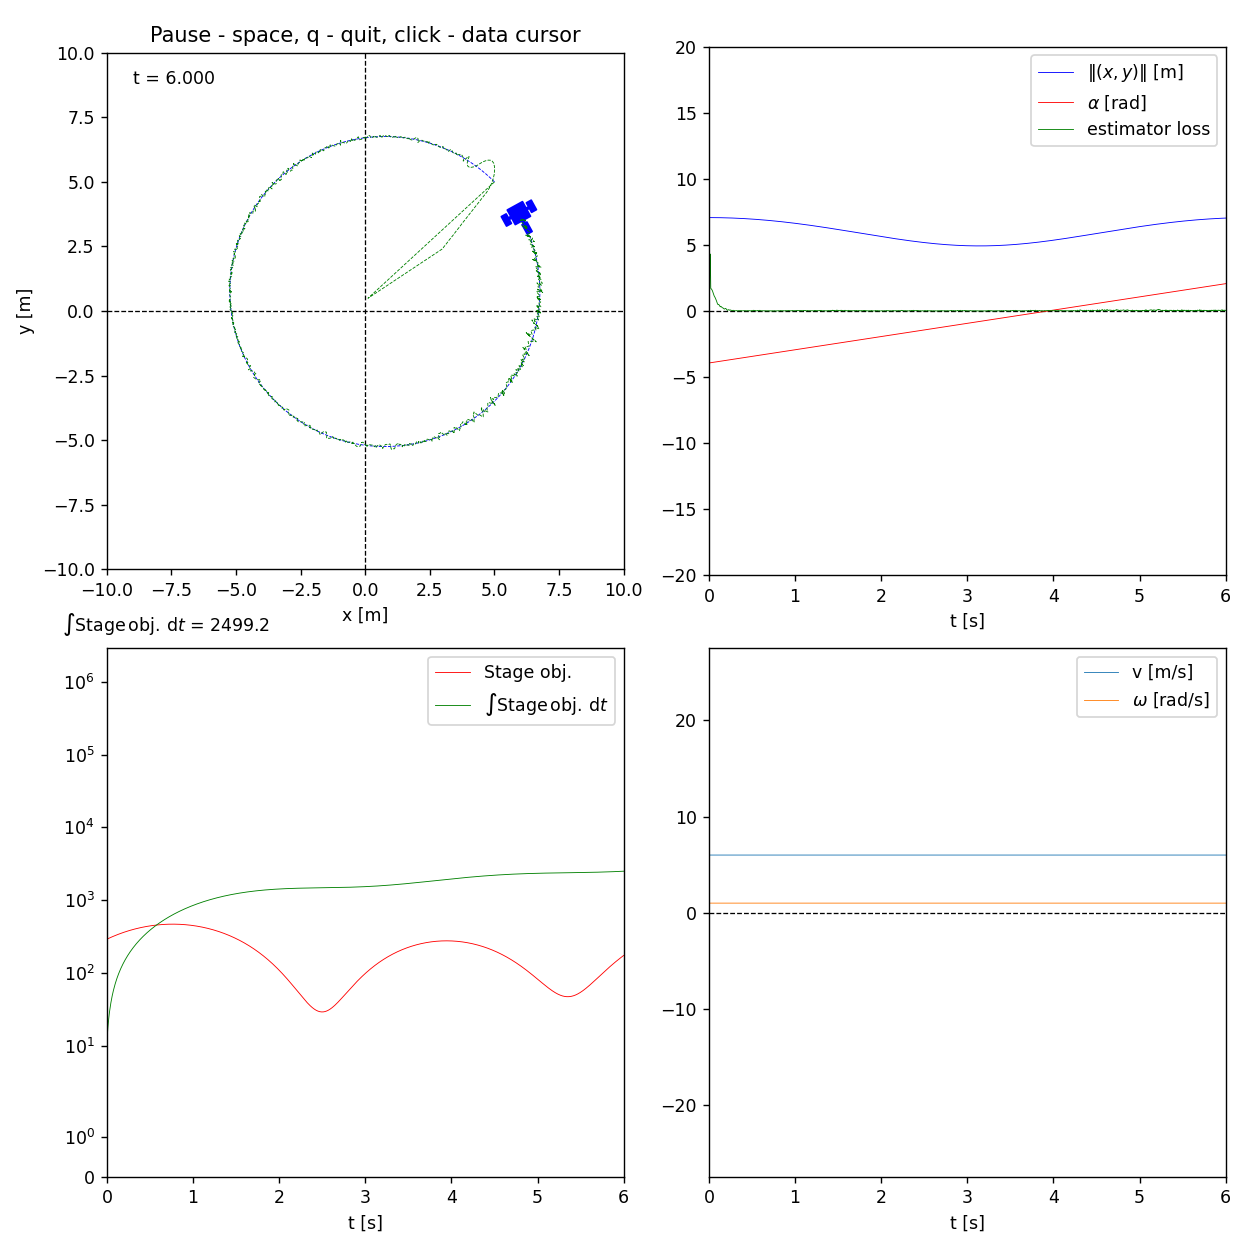

In [11]:
if is_visualization:
    state_full_init = my_simulator.state_full
    
    my_animator = Animator3WRobotNI_WithEstimator(objects=(my_simulator,
                                                     my_sys,
                                                     my_ctrl_nominal,
                                                     my_ctrl_benchm,
                                                     datafiles,
                                                     controllers.ctrl_selector,
                                                     my_logger),
                                            pars=(state_init,
                                                  action_init,
                                                  t0,
                                                  t1,
                                                  state_full_init,
                                                  xMin,
                                                  xMax,
                                                  yMin,
                                                  yMax,
                                                  ctrl_mode,
                                                  action_manual,
                                                  v_min,
                                                  omega_min,
                                                  v_max,
                                                  omega_max,
                                                  Nruns,
                                                  is_print_sim_step,
                                                  is_log_data, False, []))

    anm = animation.FuncAnimation(my_animator.fig_sim,
                                  my_animator.animate,
                                  init_func=my_animator.init_anim,
                                  blit=False, interval=dt/1e6, repeat=True)
    
    my_animator.get_anm(anm)
    
    cId = my_animator.fig_sim.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, anm))
    
    anm.running = True
    
    my_animator.fig_sim.tight_layout()
    
    plt.show()

## Final report, grading & outro

Now, after the simulation has finished, let us assess the performance of the model. In order to do so we have to compare the difference between the predicted next states and real ones with the same thing for a different estimator, because the bare number is not meaningful. Let us use a simplest estimator possible - it will give its input state as an output. Surprisingly enough, it will give outstandingly good results in comparison to the learned one.

There are several factors overlapping here. First, *dt* (step size) of the simulation is small (go check *argparser* for its value). Consequently, the robot barely moves, and subsequent observations are close to each other. Second, we do not have very much data, the trajectory consists of nearly $400$ samples.

In this problem the hyperparameters are crucially important. Avoid changing *lr* randomly until it works :)

The grade is calculated out of the model's performance on the tail part of the trajectory (approximately one third), when the convergence of the model is more or less reached. The values of the average deviation by $L_1$ and $MSE$ are compared to the ones of the author's solution.

The performance of the trivial estimator (*predicted_state* = *previous_state*) are given for reference. The advantages of the estimator become evident case of long prediction horizons (more than one step), complex control signals. Looking ahead, we will need that while working on MPC. But that's a whole another story.

In case of any questions, reach out to Ilya Osokin (@elijahmipt) or Georgy Malaniya (@OdinManiac) on Telegram.

<IPython.core.display.Javascript object>


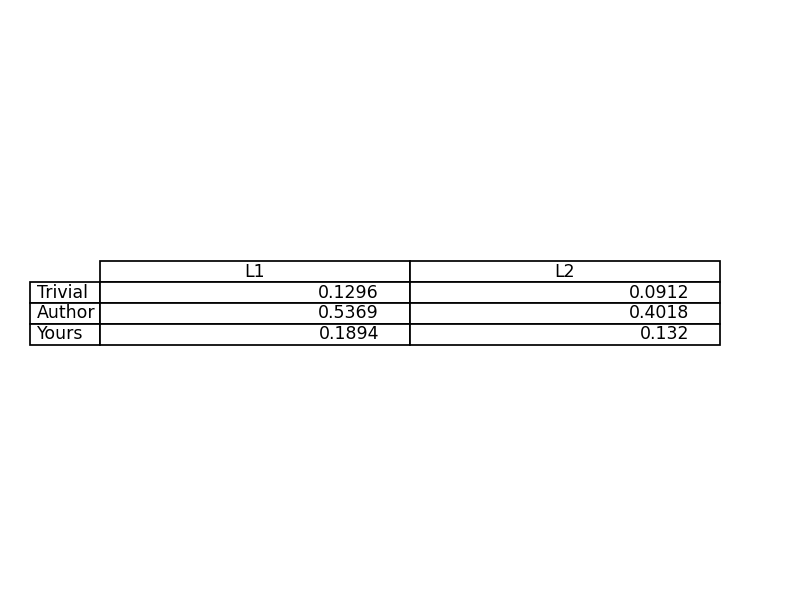

Your grade is  100 out of 100


<IPython.core.display.Javascript object>


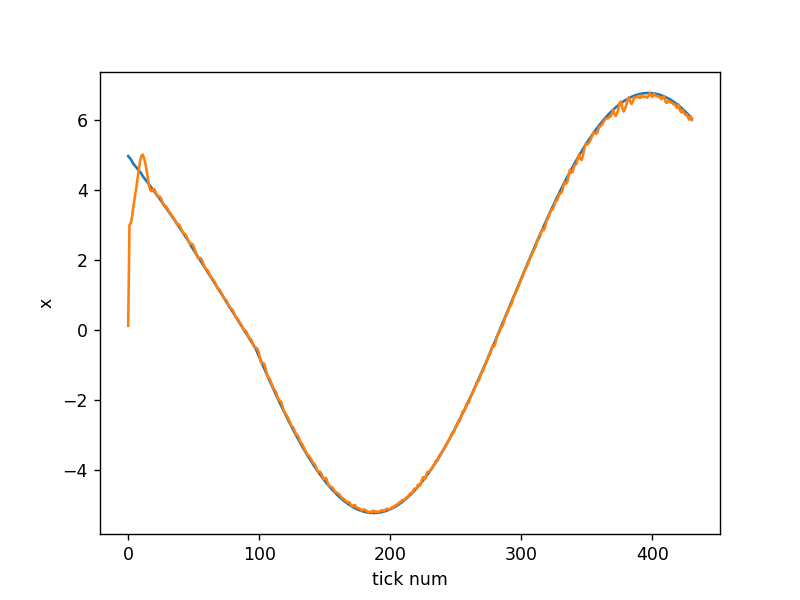

<IPython.core.display.Javascript object>


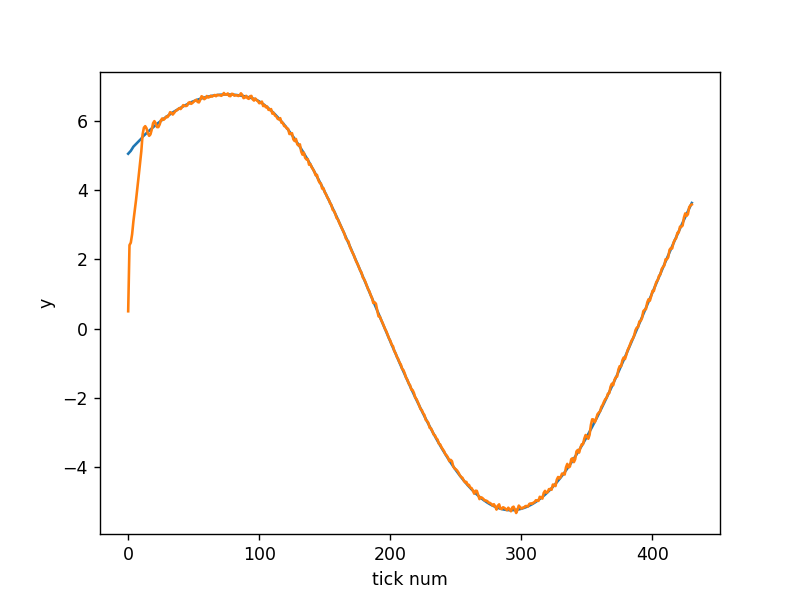

<IPython.core.display.Javascript object>


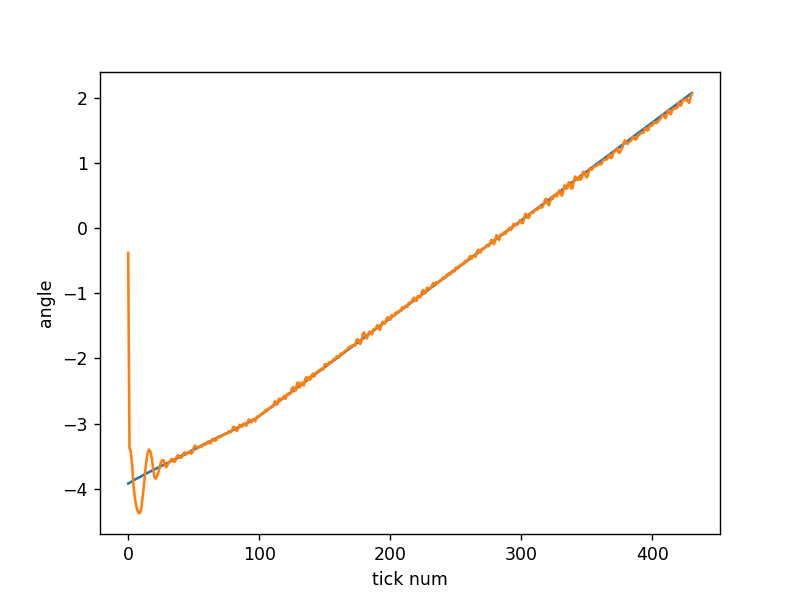

In [14]:
def mean_metric(pred, ref, shift=50, end=-1, norm=2):
    s = 0
    
    if (end == -1):
        end = len(pred)
        
    for i in range(shift, end):
        diff = pred[i] - ref[i]
        
        s += np.linalg.norm(diff, norm)
    
    s /= (len(pred) - shift)
        
    return s

shift = 100

l1_pred = mean_metric(my_animator.obs_traj[1:], my_animator.pred_traj[:-1], shift=shift, norm=1)
l1_triv = mean_metric(my_animator.obs_traj[1:], my_animator.obs_traj[:-1], shift=shift, norm=1)

l2_pred = mean_metric(my_animator.obs_traj[1:], my_animator.pred_traj[:-1], shift=shift, norm=2)
l2_triv = mean_metric(my_animator.obs_traj[1:], my_animator.obs_traj[:-1], shift=shift, norm=2)

fig, ax = plt.subplots(1,1)

data=[[l1_triv, l2_triv],
      [0.5369, 0.4018],
      [l1_pred, l2_pred]]

rounding = 10e3

for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = float(int(data[i][j] * rounding)) / rounding

column_labels=["L1", "L2"]
row_labels=["Trivial", "Author", "Yours"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels, rowLabels=row_labels,loc="center")

plt.show()

def calc_grade(max_points, ref_err, stud_err, loyalty_coeff = 3, max_error_coeff = 7):
    grade = max_points
    
    if (stud_err > ref_err * loyalty_coeff):
        grade = max_points * (1 - (stud_err - ref_err * loyalty_coeff) /
                              (ref_err * (max_error_coeff - loyalty_coeff)))
    
    grade = max(grade, 0)
    
    return grade

max_grade = 100

grade = min(calc_grade(max_grade, data[1][0], l1_pred), calc_grade(max_grade, data[1][1], l2_pred))

print("Your grade is ", "\033[92m{}\033[0m".format(str(int(grade)) + " out of " + str(max_grade)))

axes = ["x", "y", "angle"]

for i in range(len(axes)):
    tro = [a[i] for a in my_animator.obs_traj]
    trp = [a[i] for a in my_animator.pred_traj]

    #trtriv = [a[i] for a in my_animator.obs_traj[1:]]

    fig, ax = plt.subplots()
    ax.set_xlabel('tick num')
    ax.set_ylabel(axes[i])
    ax.plot(tro)
    ax.plot(trp)
    #ax.plot(trtriv)

plt.show()

In [13]:
my_animator.save_trajectory_to_file("simulation")

State-action trajectory of  0  samples
{'trajectory_log': {'observation_action_traj': []}}
